In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Extract columns from dataframe
df_cur1 = pd.read_csv('20120102_EU.csv')
cur1_col1 = df_cur1.iloc[:, 0:1].values
#cur1_col2 = df_cur1.iloc[1]

df_cur2 = pd.read_csv('20120102_EC.csv')
cur2_col1 = df_cur2.iloc[:, 0:1].values
#cur2_col2 = df_cur2.iloc[1]

In [3]:
# Sample size parameter
samplesize = 500

other_ratio, this_ratio, cur1_localmax, cur2_localmax, cur1_localmin, cur2_localmin = ([] for i in range(6))

for i in range(samplesize, len(cur1_col1)-1):
    # Get localmaxes and localmins respectively from extracted datasets
    '''
    IMPROVE MIN | MAX alg speed
    O(4n^N) <- terrible
    '''
    cur1_localmax.insert(i-samplesize, float(max(cur1_col1[i-samplesize:i-1])))
    cur2_localmax.insert(i-samplesize, float(max(cur2_col1[i-samplesize:i-1])))
    cur1_localmin.insert(i-samplesize, float(min(cur1_col1[i-samplesize:i-1])))
    cur2_localmin.insert(i-samplesize, float(min(cur2_col1[i-samplesize:i-1])))
    
    # Array boundary precausions
    if i > 0:
        # Calculate ratios
        o_r = (cur2_col1[i] - cur2_localmin[i-samplesize-1])/(cur2_localmax[i-samplesize-1] - cur2_localmin[i-samplesize-1])
        t_r = (cur1_col1[i] - cur1_localmin[i-samplesize-1])/(cur1_localmax[i-samplesize-1] - cur1_localmin[i-samplesize-1])
        # Prevent o_r !E {[0,1]}
        if o_r > 1:
            other_ratio.insert(i-samplesize, 1)
        elif o_r < 0:
            other_ratio.insert(i-samplesize, 0)
        else:
            other_ratio.insert(i-samplesize, o_r)
            
        if t_r > 1:
            this_ratio.insert(i-samplesize, 1)
        elif t_r < 0:
            this_ratio.insert(i-samplesize, 0)
        else:
            this_ratio.insert(i-samplesize, t_r)

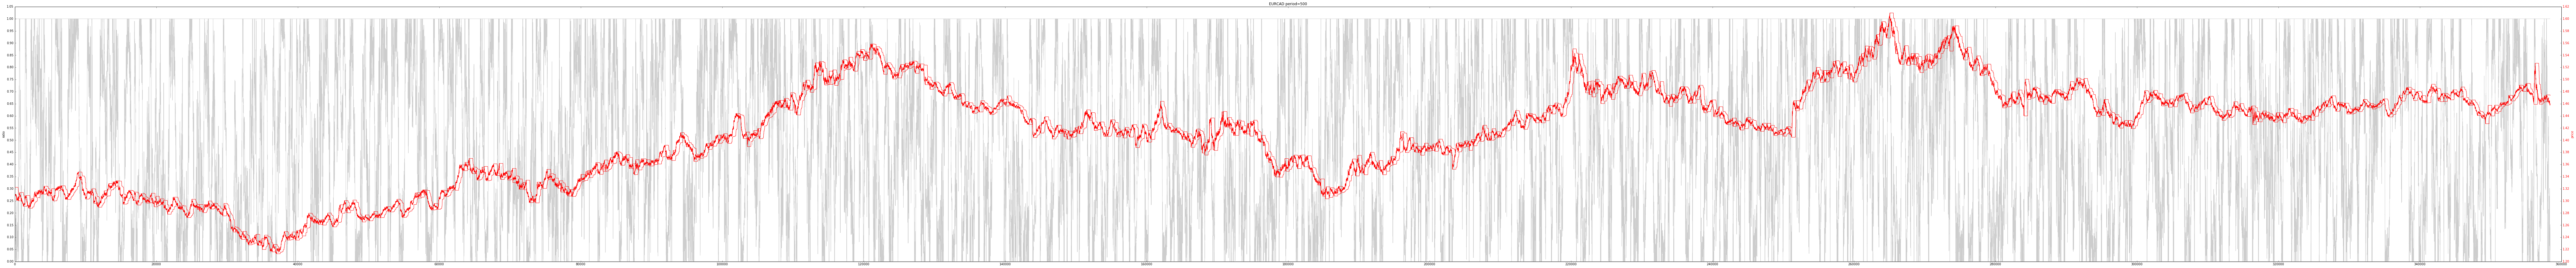

In [4]:
# Preparing to plot on multiple y-axes
fig = plt.figure(figsize=(150, 15))
ax1 = fig.add_subplot(111)

ax1.plot(other_ratio, '#cdcdcd')
ax1.plot([1]*len(other_ratio), '#cdcdcd', linewidth=1.0)
ax1.plot([0]*len(other_ratio), '#cdcdcd', linewidth=1.0)
ax1.set_ylabel('ratio')
ax1.locator_params(nbins=30)

# Add subplot with different axis range
ax2 = ax1.twinx()
ax2.plot(cur2_localmax, 'r', linewidth=1.0)
ax2.plot(cur2_localmin, 'r', linewidth=1.0)
ax2.plot(cur2_col1[samplesize:len(other_ratio)+samplesize], 'r', linewidth=1.0)
ax2.locator_params(nbins=30)
ax2.set_ylabel('price', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

plt.title('EURCAD period=' + str(samplesize))
plt.xlabel('(ticks)')
#plt.show()
plt.savefig('EURCAD_coint.pdf')

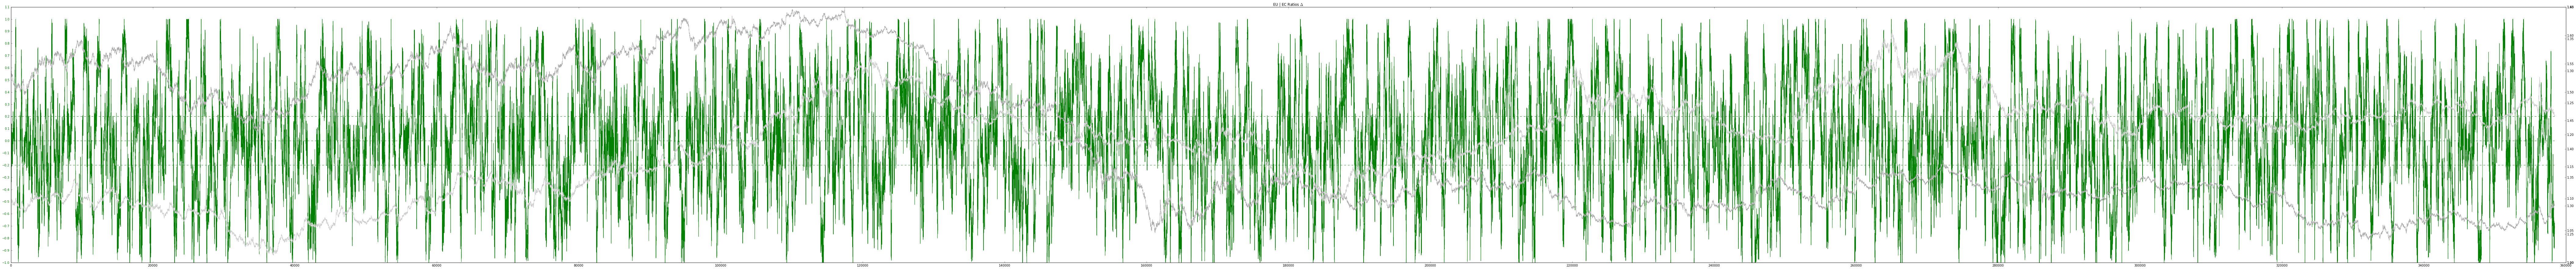

In [5]:
# Visualize ratio with currencies
# ---

fig2 = plt.figure(figsize=(150, 15))
ax2_1 = fig2.add_subplot(111)
ax2_2 = fig2.add_subplot(111)

# Calculate ratio delta array
delta = [other_ratio[i] - this_ratio[i] for i in range(len(other_ratio))]

# Plot delta with thresholds
ax2_2.plot(delta, 'g')
ax2_2.plot([0.2]*len(other_ratio), 'g--')
ax2_2.plot([0]*len(other_ratio), 'g--')
ax2_2.plot([-0.2]*len(other_ratio), 'g--')

for tl in ax2_1.get_yticklabels():
    tl.set_color('g')
'''
ax2_1.plot(this_ratio, 'r')
ax2_1.plot(other_ratio, 'b')
'''
ax2_1.twinx().plot(cur2_col1[samplesize:len(other_ratio)+samplesize], '#cdcdcd', linewidth=1.0)
ax2_1.twinx().plot(cur1_col1[samplesize:len(other_ratio)+samplesize], '#adadad', linewidth=1.0)
ax2_1.locator_params(nbins=30)
plt.title('EU | EC Ratios $\Delta$')
plt.savefig('ratios_coint.pdf')
#plt.show()

In [136]:
# Simple backtesting engine for hedging pairs trading
# ---

class order():
    def order_open(self):
        pass
    def order_close(self):
        pass
    

trade_1 = 0 #EURUSD 
trade_2 = 0 #EURCAD
ev, ev_1, ev_2 = [0]*3
open_rates = [0]*2
entryvals =  [0]*len(delta)
typevals =   [0]*len(delta)

# Exitvals 1 & 2 because of positions on two symbols
exitvals_1 = [0]*len(delta)
exitvals_2 = [0]*len(delta)
net_pips_1 = [0]
net_pips_2 = [0]
np_1 = 1 #(net pips iter)
np_2 = 1

wins = 0
losses = 0

# Parameters
# > compute sl/tp as fraction of volatility / ML-smarts
deltaval = 0.25
target_1 = 1#0.005
stop_1 = 0.007
target_2 = 1#0.005
stop_2 = 0.007

for x in range(len(other_ratio)):
    # if all closed
    if trade_1 == trade_2 == 0:
        if delta[x] >= deltaval:
            tradetype = 1
            open_rates[0] = cur1_col1[samplesize+x]
            open_rates[1] = cur2_col1[samplesize+x]
            # Trades = open
            trade_1 = 1
            trade_2 = 1
            entryvals[ev] = x # Store position in delta array
            typevals[ev] = 1
            ev += 1

        elif delta[x] <= -deltaval:
            tradetype = 0
            open_rates[0] = cur1_col1[samplesize+x]
            open_rates[1] = cur2_col1[samplesize+x]
            # Trades = open
            trade_1 = 1
            trade_2 = 1
            entryvals[ev] = x # Store position in delta array
            typevals[ev] = 0
            ev += 1
            
    
    # if >0 open
    else:
        # <>
        if tradetype == 1:
            if trade_1 == 1:
                if -0.01 < delta[x] < 0.01:
                    net_pips_1.insert(np_1, net_pips_1[np_1-1] + (open_rates[0] - cur1_col1[samplesize+x])*10000)
                    np_1 += 1
                    trade_1 = 0
                    exitvals_1[ev_1] = x # Store position in delta array
                    ev_1 += 1
                    if open_rates[0] < cur1_col1[samplesize+x]:
                        losses += 1
                    else:
                        wins += 1
                    continue
                    
                if cur1_col1[samplesize+x] <= open_rates[0] - target_1 or cur1_col1[samplesize+x] >= open_rates[0] + stop_1:
                    # > Adjust pips by EC/EU worth
                    net_pips_1.insert(np_1, net_pips_1[np_1-1] + (open_rates[0] - cur1_col1[samplesize+x])*10000)
                    np_1 += 1
                    trade_1 = 0
                    exitvals_1[ev_1] = x # Store position in delta array
                    ev_1 += 1
                    if open_rates[0] < cur1_col1[samplesize+x]:
                        losses += 1
                    else:
                        wins += 1
                    
            if trade_2 == 1:
                if -0.01 < delta[x] < 0.01:
                    net_pips_2.insert(np_2, net_pips_2[np_2-1] + (cur2_col1[samplesize+x] - open_rates[1])*10000)
                    np_2 += 1
                    trade_2 = 0
                    exitvals_2[ev_2] = x # Store position in delta array
                    ev_2 += 1
                    if open_rates[1] > cur2_col1[samplesize+x]:
                        losses += 1
                    else:
                        wins += 1
                    continue
                    
                if cur2_col1[samplesize+x] >= open_rates[0] + target_2 or cur1_col1[samplesize+x] >= open_rates[0] + stop_2:
                    # > Adjust pips by EC/EU worth
                    net_pips_2.insert(np_2, net_pips_2[np_2-1] + (open_rates[1] - cur2_col1[samplesize+x])*10000)
                    np_2 += 1
                    trade_2 = 0
                    exitvals_2[ev_2] = x # Store position in delta array
                    ev_2 += 1
                    if open_rates[1] > cur2_col1[samplesize+x]:
                        losses += 1
                    else:
                        wins += 1
        
        # ><
        else:
            if trade_1 == 1:
                if -0.01 < delta[x] < 0.01:
                    net_pips_2.insert(np_2, net_pips_2[np_2-1] + (cur2_col1[samplesize+x] - open_rates[1])*10000)
                    np_2 += 1
                    trade_1 = 0
                    exitvals_1[ev_1] = x # Store position in delta array
                    ev_1 += 1
                    if open_rates[1] > cur2_col1[samplesize+x]:
                        losses += 1
                    else:
                        wins += 1
                    continue

                if cur2_col1[samplesize+x] >= open_rates[0] + target_2 or cur1_col1[samplesize+x] >= open_rates[0] + stop_2:
                    # > Adjust pips by EC/EU worth
                    net_pips_2.insert(np_2, net_pips_2[np_2-1] + (cur2_col1[samplesize+x] - open_rates[1])*10000)
                    np_2 += 1
                    trade_1 = 0
                    exitvals_1[ev_1] = x # Store position in delta array
                    ev_1 += 1
                    if open_rates[1] < cur2_col1[samplesize+x]:
                        losses += 1
                    else:
                        wins += 1
                    
            if trade_2 == 1:
                if -0.01 < delta[x] < 0.01:
                    net_pips_1.insert(np_1, net_pips_1[np_1-1] + (open_rates[0] - cur1_col1[samplesize+x])*10000)
                    np_1 += 1
                    trade_2 = 0
                    exitvals_2[ev_2] = x # Store position in delta array
                    ev_2 += 1
                    if open_rates[0] < cur1_col1[samplesize+x]:
                        losses += 1
                    else:
                        wins += 1
                    continue
                    
                if cur1_col1[samplesize+x] <= open_rates[0] - target_1 or cur1_col1[samplesize+x] >= open_rates[0] + stop_1:
                    # > Adjust pips by EC/EU worth
                    net_pips_1.insert(np_1, net_pips_1[np_1-1] + (open_rates[0] - cur1_col1[samplesize+x])*10000)
                    np_1 += 1
                    trade_2 = 0
                    exitvals_2[ev_2] = x # Store position in delta array
                    ev_2 += 1
                    if open_rates[0] < cur1_col1[samplesize+x]:
                        losses += 1
                    else:
                        wins += 1

# Store rates in arrays
def getOpenRates(rate1, rate2):
    open_rates = [0]*2
    open_rates[0] = rate1
    open_rates[1] = rate2
    return open_rates

    '''
    >
    fix target issue
    fix spread consideration
    
    consider intrinsic pip value
    expand on class to simplify clause
        enable support for other strategies
    attempt pyfolio support
    '''

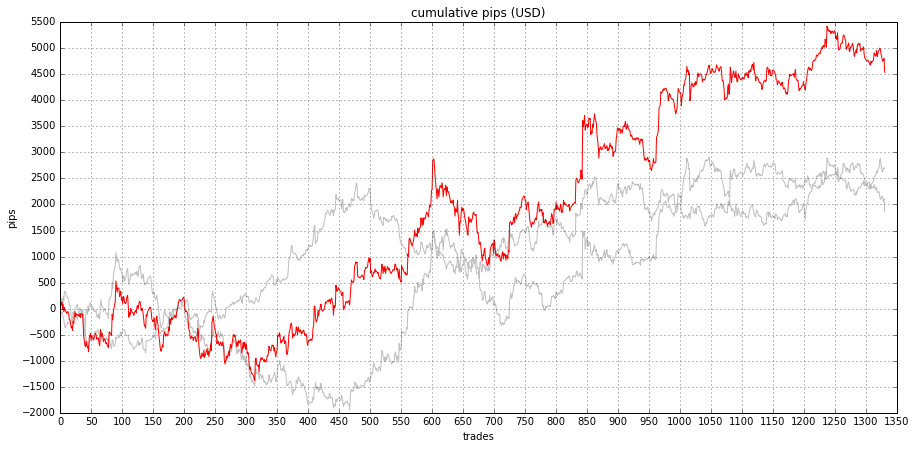

wins: 1393
losses: 1267
win%: 0.5236842105263158


In [138]:
# Profit plot
# ---

# 1.32 = EURCAD/EURUSD
# - 4 = 2 pips crossing 2 spreads
cumulative_net = [net_pips_1[i]*1.32 + net_pips_2[i] for i in range(len(net_pips_1))]
net_pips_1_1 = [net_pips_1[j]*1.32 for j in range(len(net_pips_1))]

fig4 = plt.figure(figsize = (15, 7))
ax3 = fig4.add_subplot(111)
ax3.plot(net_pips_1_1, '#bfbfbf')
ax3.plot(net_pips_2, '#bfbfbf')
ax3.plot(cumulative_net, 'r')
ax3.locator_params(nbins=30)
plt.title('cumulative pips (USD)')
ax3.set_xlabel('trades')
ax3.set_ylabel('pips')
ax3.grid()
plt.show()

print('wins:', wins)
print('losses:', losses)
print('win%:', wins/(wins+losses))

#https://github.com/quantopian/pyfolio/blob/master/pyfolio/examples/overview_slides.ipynb

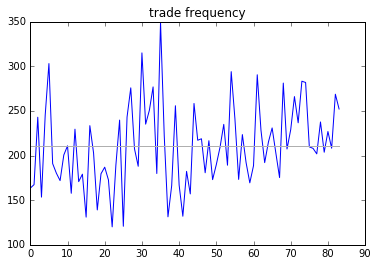

In [135]:
# Plot approximate trade frequency
to_int = []
for nn in range(len(entryvals)):
    if nn > 0 and entryvals[nn] == 0:
        break
    to_int.insert(nn, entryvals[nn])

int_ = []
for evi in range(20, len(to_int), 20):
    int_.insert(evi, (to_int[evi] - to_int[evi-20])/20)

plt.plot(int_)
plt.plot([sum(int_)/len(int_)]*len(int_), '#afafaf')
plt.title('trade frequency')
plt.show()

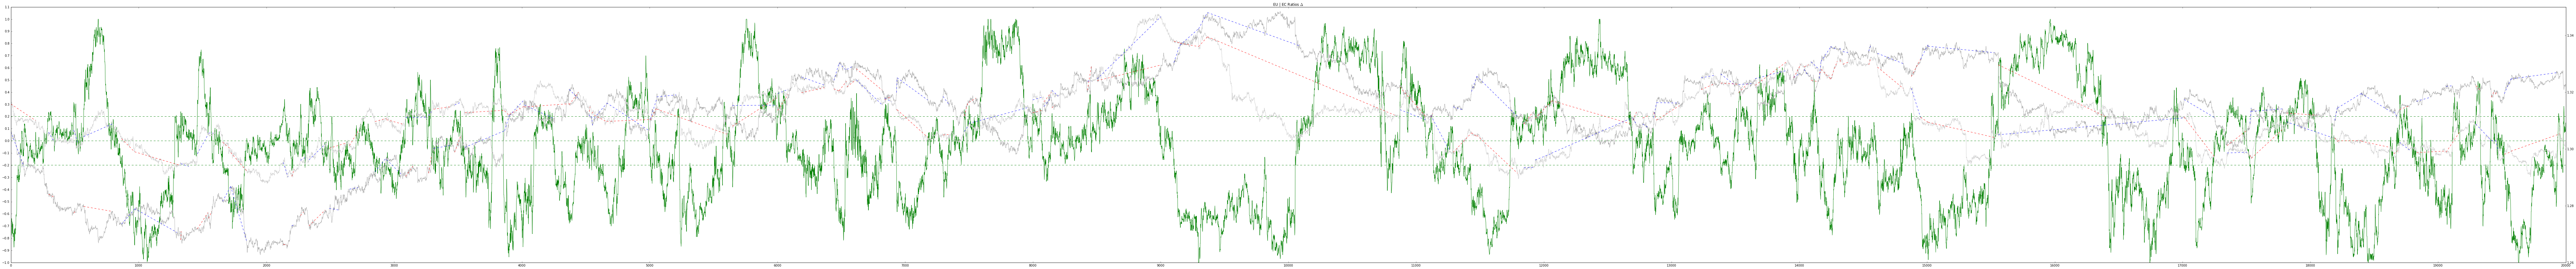

In [125]:
render_lim = 20000
render_shift = 0 #200000

fig5 = plt.figure(figsize=(150, 15))
#ax5_1 = fig5.add_subplot(111)
ax5_2 = fig5.add_subplot(111)

# Calculate ratio delta array
#delta = [other_ratio[i] - this_ratio[i] for i in range(len(other_ratio))]

# Plot delta with thresholds
ax5_2.plot(delta[render_shift:render_lim + render_shift], 'g')
ax5_2.plot([0.2]*render_lim, 'g--')
ax5_2.plot([0]*render_lim, 'g--')
ax5_2.plot([-0.2]*render_lim, 'g--')

for tl in ax2_1.get_yticklabels():
    tl.set_color('g')

# Plot correctly shifted quote values
ax5_2.locator_params(nbins=30)
ax5_twinx = ax5_2.twinx()
ax5_twinx.plot(cur2_col1[samplesize + render_shift:render_lim + render_shift + samplesize], '#cdcdcd', linewidth=1.0)
ax5_twinx.plot(cur1_col1[samplesize + render_shift:render_lim + render_shift + samplesize], '#adadad', linewidth=1.0)

# Fast forward to correct entry/exit values in terms of render shift input
# Limiting backtester to a theoretical 99999 trades
for p in range(99999): 
    break

for k in range(render_lim):
    if exitvals_1[k] > render_lim and exitvals_2[k] > render_lim:
        break
    else:
        # Color trade-lines by type (<> | ><)
        if typevals[k] == 1:
            ax5_twinx.plot([entryvals[k], exitvals_1[k]], [cur1_col1[samplesize + entryvals[k]], cur1_col1[samplesize + exitvals_1[k]]], 'r--')
            ax5_twinx.plot([entryvals[k], exitvals_2[k]], [cur2_col1[samplesize + entryvals[k]], cur2_col1[samplesize + exitvals_2[k]]], 'b--')
        else:
            ax5_twinx.plot([entryvals[k], exitvals_1[k]], [cur1_col1[samplesize + entryvals[k]], cur1_col1[samplesize + exitvals_1[k]]], 'b--')
            ax5_twinx.plot([entryvals[k], exitvals_2[k]], [cur2_col1[samplesize + entryvals[k]], cur2_col1[samplesize + exitvals_2[k]]], 'r--')
        
plt.title('EU | EC Ratios $\Delta$')
plt.savefig('ratios_coint.pdf')
#plt.show()